
# I think it was the old way to plot the results. now it should be the other two files that plots it.

---

In [24]:
import sys
sys.path.append("C:\ZSOMBI\OneDrive\PoPy")
sys.path.append("/Users/zsombi/OneDrive/PoPy")

import pandas as pd
import tqdm

from popy.decoding.decoder_tools import mask_N_consecutives
from popy.io_tools import load_behavior, load_neural_data
from popy.behavior_data_tools import *
from popy.neural_data_tools import time_normalize_session, scale_neural_data, remove_low_fr_neurons, remove_trunctuated_neurons, add_firing_rates
from popy.decoding.population_decoders import *
from popy.plotting.plotting_tools import plot_keypoints
import popy.config as cfg
#import statsmodels.formula.api as smf
#import statsmodels.api as sm
from popy.io_tools import load_metadata
import os
#from matplotlib_venn import venn3, venn3_circles
from itertools import product

import matplotlib.pyplot as plt


def print_intersection(set1, set2, set3):
    # Intersection of all three sets
    intersection_all = set1 & set2 & set3
    print("Intersection of all:", list(intersection_all)[:5])

    # Intersection of set1 and set2 but not set3
    intersection_12 = (set1 & set2) - set3
    print("Intersection of set1 and set2 but not set3:", list(intersection_12)[:5])

    # Intersection of set1 and set3 but not set2
    intersection_13 = (set1 & set3) - set2
    print("Intersection of set1 and set3 but not set2:", list(intersection_13)[:5])

    # Intersection of set2 and set3 but not set1
    intersection_23 = (set2 & set3) - set1
    print("Intersection of set2 and set3 but not set1:", list(intersection_23)[:5])

    # Only in set1
    only_set1 = set1 - (set2 | set3)
    print("Only in set1:", list(only_set1)[:5])

    # Only in set2
    only_set2 = set2 - (set1 | set3)
    print("Only in set2:", list(only_set2)[:5])

    # Only in set3
    only_set3 = set3 - (set1 | set2)
    print("Only in set3:", list(only_set3)[:5])
    

def show_glm_results(data, plim=0.05, xlim=None, title=None):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharey=True)
    if not title is None:
        plt.suptitle(title)

    time_vector = data.time.values

    for m, monkey in enumerate(['ka', 'po']):
        for a, area in enumerate(['LPFC', 'MCC']):
            ax = axs[m, a]
            # set background color to grey
            ax.set_facecolor('lightgrey')

            data_curr = data[data.area == area]
            data_curr = data_curr[data_curr.monkey == monkey]

            # sort based on mean t_val
            data_curr = data_curr.sortby(data_curr.mean(axis=1)*np.count_nonzero(~np.isnan(data_curr), axis=1), ascending=True)

            # imshow with no smoothing
            cbar = ax.imshow(data_curr, aspect='auto', origin='lower', cmap='RdBu_r', extent=[time_vector[0], time_vector[-1], 0, len(data_curr.unit)], interpolation='none', vmin=-15, vmax=15)
            # nan values to white
            cbar.cmap.set_bad(color='white')
            plt.colorbar(cbar, ax=ax, label='z (coef / std err)')
            plot_keypoints(ax, fontsize=6)

            ax.plot(time_vector, (data_curr==data_curr).sum(axis=0), color='tab:red', lw=1, label=f'# signif units (p<{plim})', alpha=0.5)
            ax.legend(loc='upper left')
            ax.set_title(f'monkey: {monkey}, area: {area}')

            ax.grid(axis='x')
            ax.set_ylabel('unit')

            if xlim is not None:
                ax.set_xlim(xlim)
    plt.tight_layout()
    
    return fig, axs


def plot_prop_signif_units(data, plim=0.05, xlim=None, title=None):
    # set times of interest
    times_of_interest = {
        'feedback': [4, 5],
        'value_function': [10, 11],
        'target': [2, 3]
    }

    fig, ax = plt.subplots(figsize=(7, 4))
    if not title is None:
        plt.suptitle(title)

    colors = {'LPFC': 'tab:blue', 'MCC': 'grey'}
    styles = {'ka': '-', 'po': '--'}
    handles, labels = [], []

    time_vector = data.time.values
    for m, monkey in enumerate(['ka', 'po']):
        for a, area in enumerate(['LPFC', 'MCC']):
            data_curr = data[data.area == area]
            data_curr = data_curr[data_curr.monkey == monkey]

            ax.plot(time_vector, (data_curr==data_curr).mean(axis=0), color=colors[area], lw=1, label=f'{monkey} {area}', linestyle=styles[monkey])

   
    # legend below plot
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

    ax.grid(axis='x', alpha=0.3)
    ax.set_ylabel('proportion of significant units')
    # hide spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # order of legend
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    handles, labels = zip(*unique)
    # switch index 1 and 2
    order = np.arange(len(handles))
    order[1], order[2] = order[2], order[1]
    fig.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='upper center', ncols=2, bbox_to_anchor=(0.5, 0.05))
    plot_keypoints(ax)

    if xlim is not None:
        ax.set_xlim(xlim)
    
    plt.tight_layout()
    
    return fig, ax

def get_grid_instances(param_grid):
    instances = []
    for current_setup in param_grid:
        # all combinations of parameters
        for grid_instance in [dict(zip(current_setup.keys(), values)) for values in product(*current_setup.values())]:  # loop over all combinations of parameters
            instances.append(grid_instance)
            
    return instances

In [25]:
def get_grid_instances(param_grid):
    instances = []
    for current_setup in param_grid:
        # all combinations of parameters
        for grid_instance in [dict(zip(current_setup.keys(), values)) for values in product(*current_setup.values())]:  # loop over all combinations of parameters
            instances.append(grid_instance)
            
    return instances

In [26]:
param_grid = [
    {'target_of_interest': [None, 1, 2, 3, 'random'],
    'fname': ['last_last_fb_reduced_cmw_cpd'],
    },
]

# Load data

In [27]:
plim = 0.05

# load data - 1-1 xarray datasets for all the conditions
dss = {}
for grid_instance in get_grid_instances(param_grid):
    floc = os.path.join(cfg.PROJECT_PATH_LOCAL, 'notebooks', 'decoders', 'glm', 'results', 
                        #f'{grid_instance["model"]}_target_{grid_instance["target_of_interest"]}',
                        f'{grid_instance["fname"]}_target_{grid_instance["target_of_interest"]}',
                        f'scores_{ grid_instance["conditions"]}.nc' if 'conditions' in grid_instance.keys() else f'scores.nc')
    
    with xr.open_dataset(floc) as ds:
        # mask with p_vals
        #ds.attrs = grid_instance
        dss[grid_instance['target_of_interest']] = ds
        print(ds)

<xarray.Dataset>
Dimensions:  (unit: 4782, time: 74)
Coordinates:
  * unit     (unit) object 'ka_230520_MCC_01_02' ... 'po_200722_MCC_15_01'
  * time     (time) float64 0.0 0.2 0.4 0.6 0.81 ... 14.19 14.39 14.59 14.8
    monkey   (unit) object ...
    session  (unit) object ...
    area     (unit) object ...
    channel  (unit) object ...
Data variables:
    scores   (unit, time) float64 ...
    p_vals   (unit, time) float64 ...
Attributes:
    bin_size:                      0.01
    step_time:                     0.2
    area:                          None
    glm_predictors:                [None]
    cpd_full_model_predictors:     ['last_fb_cmw_mixed', 'last_last_fb_cmw_mi...
    cpd_reduced_model_predictors:  ['last_fb_cmw_mixed']
    target_of_interest:            None
    model:                         value_glm_CPD
    model_scoring_function:        None
    neural_data_type:              spike_counts
    value_type:                    continuous
    fname:                       

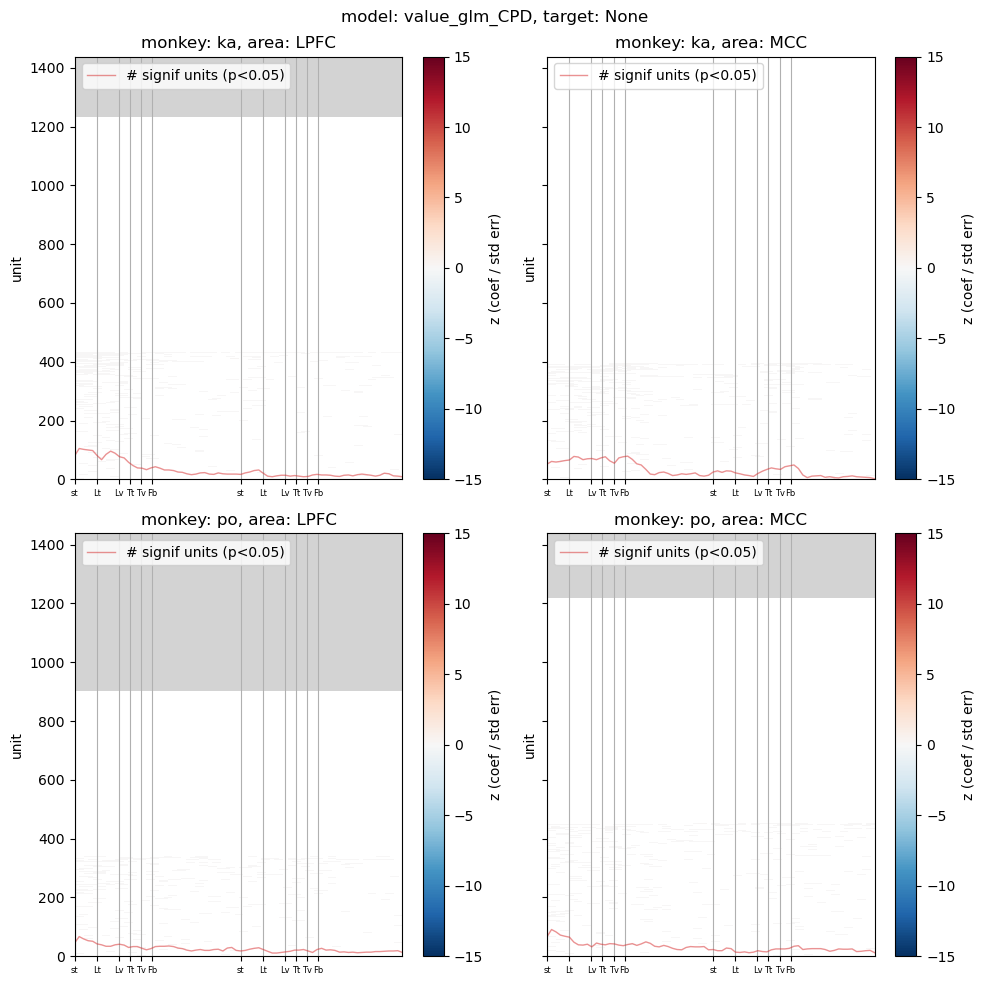

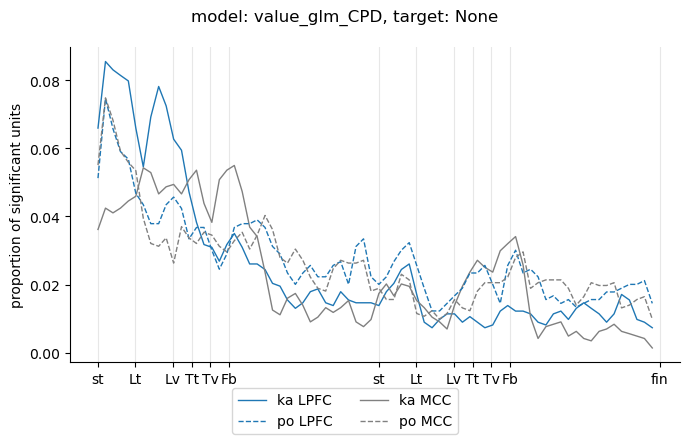

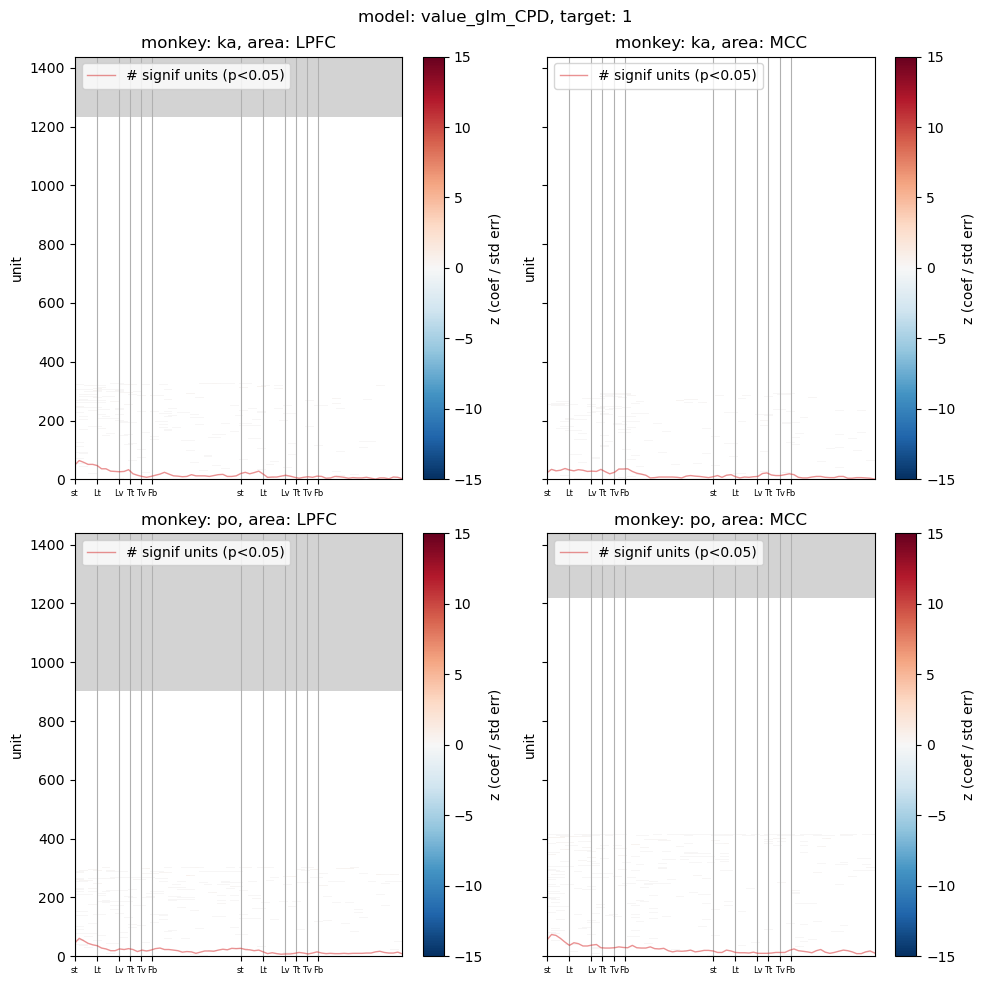

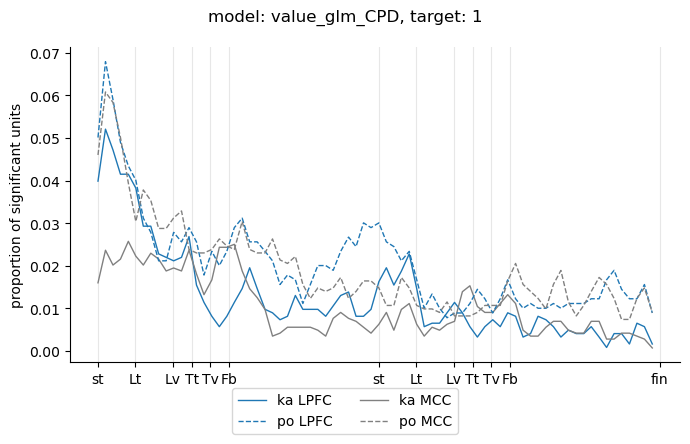

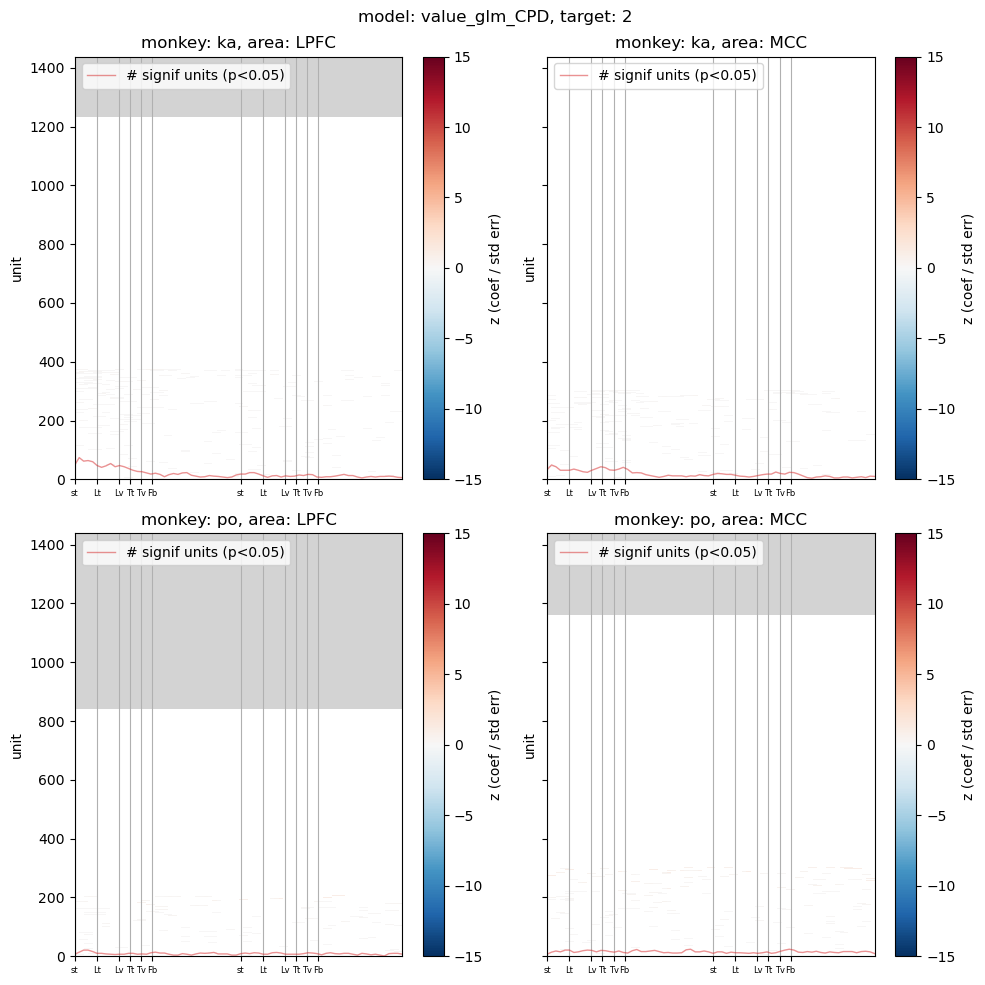

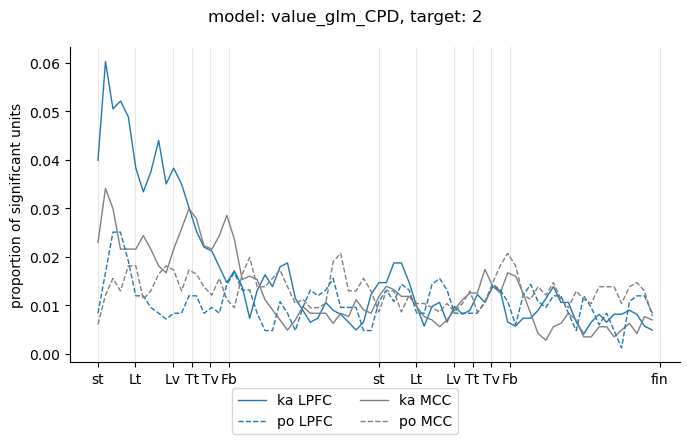

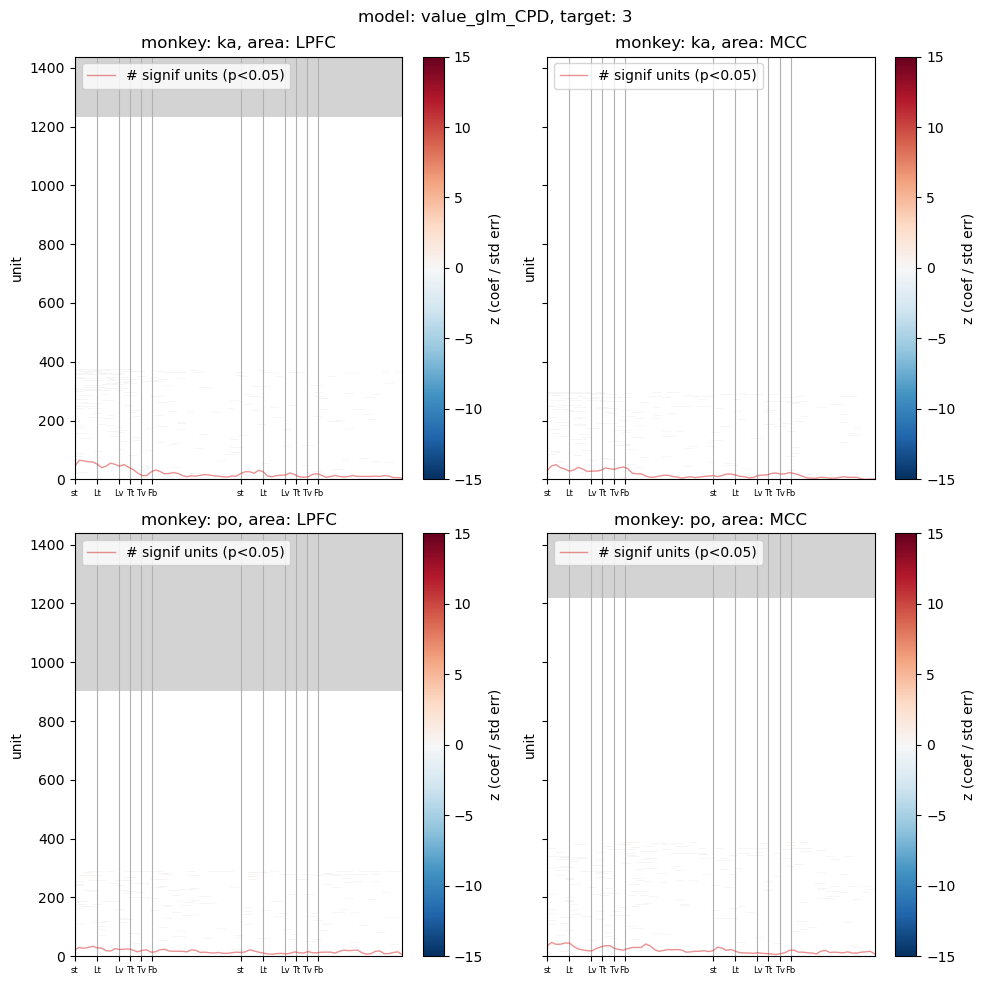

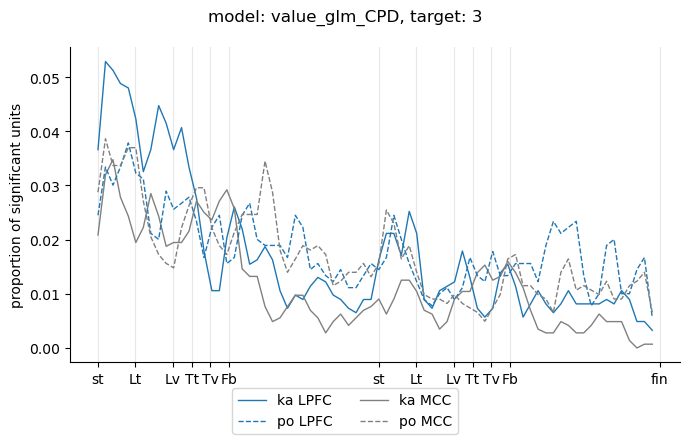

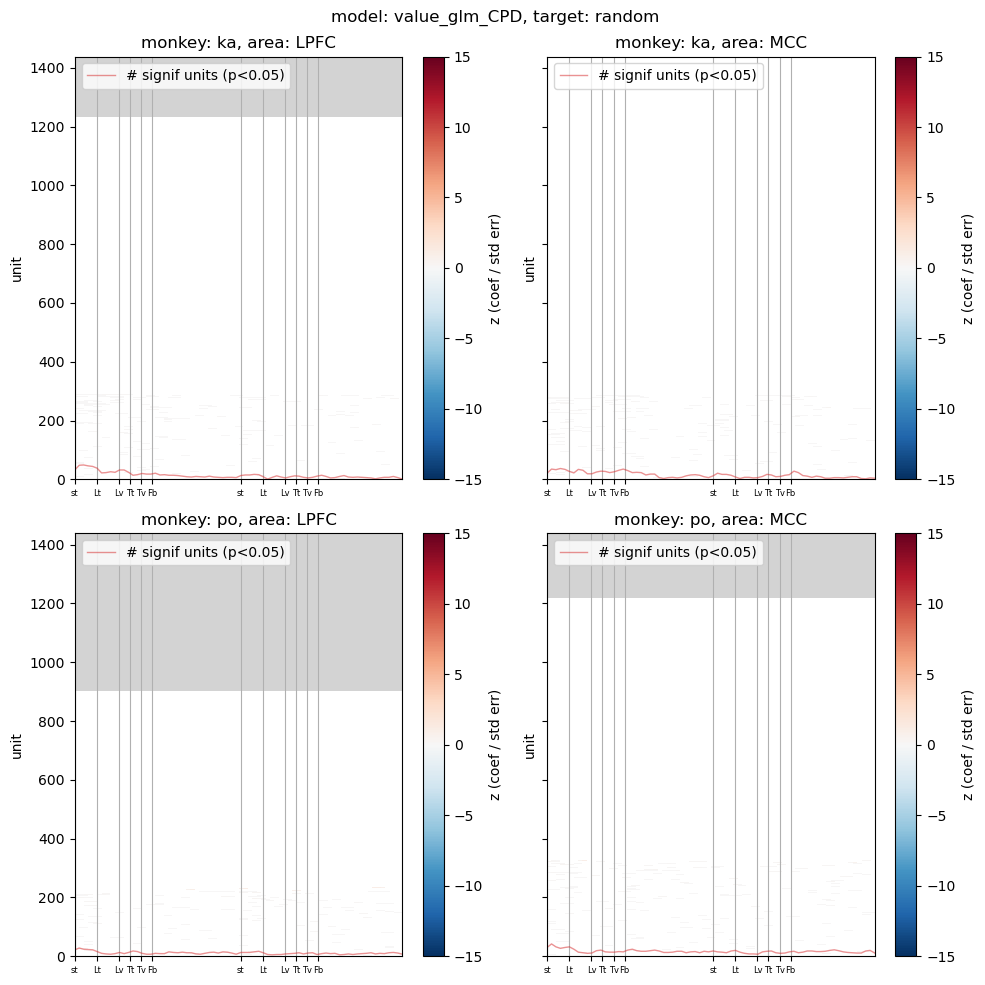

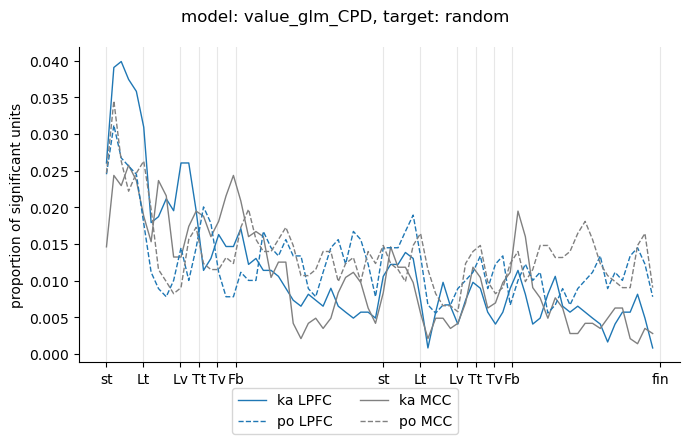

In [38]:
for target, ds in dss.items():
    data = ds['scores'].where(ds['p_vals'] < plim)
        
    # mask with N consecutive bins
    data_masked = mask_N_consecutives(data, N=2)
    #data_masked = data

    # show results
    fig, axs = show_glm_results(data_masked, plim=plim, title=f'model: {ds.attrs["model"]}, target: {target}')

    fig, axs = plot_prop_signif_units(data_masked, plim=plim, title=f'model: {ds.attrs["model"]}, target: {target}')
    

In [29]:
# in which time point do we check the significant units
time_of_interest = [10, 11.2]

list_of_untis = {'all_mcc': set(), 'all_lpfc': set()}
plim = 0.05

for target, ds in dss.items():  
    # mask with p_vals
    data = ds['scores'].where(ds['p_vals'] < plim)
    # mask with N consecutive bins
    data_masked = mask_N_consecutives(data, N=3)

    for monkey, area in product(['ka', 'po'], ['MCC', 'LPFC']):
        # get data for monkey and area
        data_masked_temp = data_masked[(data_masked.area==area) & (data_masked.monkey==monkey), (ds.time >= time_of_interest[0]) & (ds.time <= time_of_interest[1])]  # get data for time of interest

        # get significant units
        signif_units_temp = data_masked_temp.unit[np.any(~np.isnan(data_masked_temp), axis=1)].values  # get units that are significant in at least one time point of the time interval of interest
        
        # store in dictionary
        list_of_untis[f'target_{target}_{monkey}_{area}'] = signif_units_temp


In [30]:
# print units that are significant in each conditions

print(list_of_untis['target_None_ka_LPFC'])
print(list_of_untis['target_None_po_LPFC'])
print(list_of_untis['target_None_ka_MCC'])
print(list_of_untis['target_None_po_MCC'])


['ka_300720_LPFC_14_01' 'ka_050820_LPFC_04_01' 'ka_050620_LPFC_03_02'
 'ka_150221_LPFC_14_02' 'ka_030322_LPFC_13_02' 'ka_210322_LPFC_09_01'
 'ka_280622_LPFC_15_03']
['po_080920_LPFC_12_01' 'po_080920_LPFC_15_01' 'po_080920_LPFC_16_02'
 'po_111220_LPFC_06_01' 'po_180920_LPFC_08_02' 'po_141020_LPFC_11_01'
 'po_031220_LPFC_06_01' 'po_120121_LPFC_16_01' 'po_090721_LPFC_11_01'
 'po_090721_LPFC_12_01' 'po_300322_LPFC_06_01' 'po_300421_LPFC_16_02'
 'po_280721_LPFC_06_01' 'po_280721_LPFC_10_01' 'po_210422_LPFC_09_01'
 'po_310822_LPFC_09_01' 'po_180322_LPFC_04_01' 'po_180322_LPFC_08_02'
 'po_140622_LPFC_08_03' 'po_080722_LPFC_10_02' 'po_200722_LPFC_11_01']
['ka_270720_MCC_05_02' 'ka_150720_MCC_08_01' 'ka_010720_MCC_05_01'
 'ka_010720_MCC_08_01' 'ka_050620_MCC_08_02' 'ka_050620_MCC_08_03'
 'ka_050620_MCC_09_02' 'ka_050620_MCC_11_01' 'ka_190620_MCC_09_01'
 'ka_041220_MCC_12_03' 'ka_101220_MCC_05_01' 'ka_110321_MCC_12_01'
 'ka_150221_MCC_07_02' 'ka_040321_MCC_09_02' 'ka_040321_MCC_09_01'
 'ka_0403

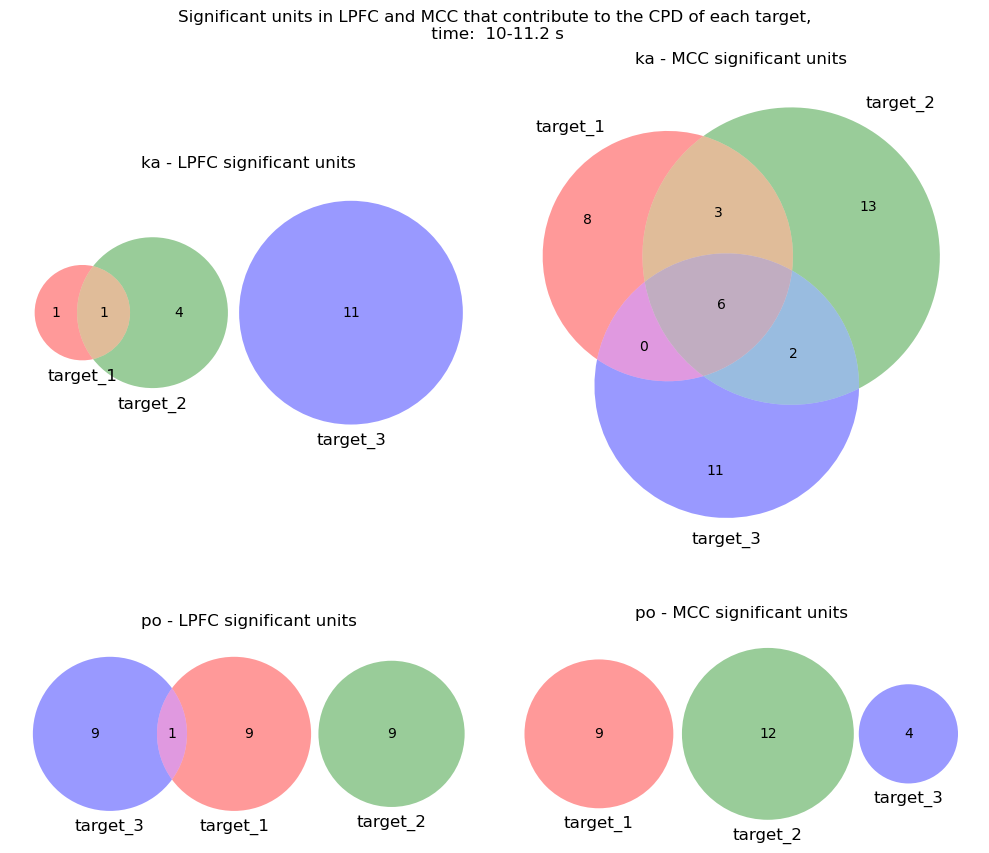

In [31]:
# plot venn diagram for target 1, 2, 3
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn2

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f'Significant units in LPFC and MCC that contribute to the CPD of each target,\n time:  {time_of_interest[0]}-{time_of_interest[1]} s')

for i, (monkey, area) in enumerate(product(['ka', 'po'], ['LPFC', 'MCC'])):
    ax = axs.flatten()[i]
    venn3([set(list_of_untis[f'target_{target}_{monkey}_{area}']) for target in [1, 2, 3]], set_labels=['target_1', 'target_2', 'target_3'], ax=ax)
    ax.set_title(f'{monkey} - {area} significant units')

plt.tight_layout()
plt.show()

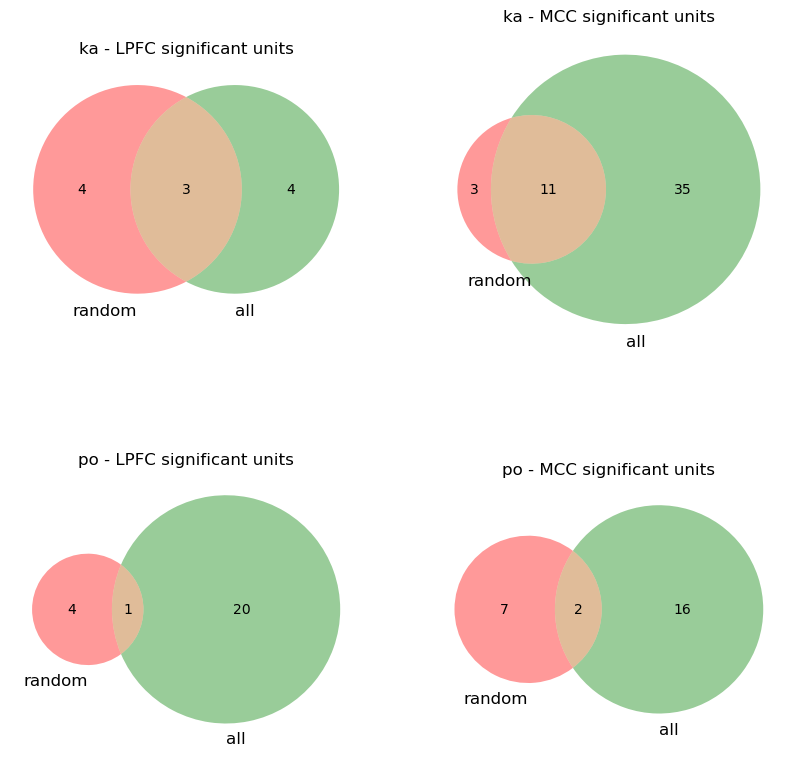

In [32]:
# plot venn diagram for random vs all units condition
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i, (monkey, area) in enumerate(product(['ka', 'po'], ['LPFC', 'MCC'])):
    ax = axs.flatten()[i]
    venn2([set(list_of_untis[f'target_{target}_{monkey}_{area}']) for target in ['random', None]], set_labels=['random', 'all'], ax=ax)
    ax.set_title(f'{monkey} - {area} significant units')

plt.show()

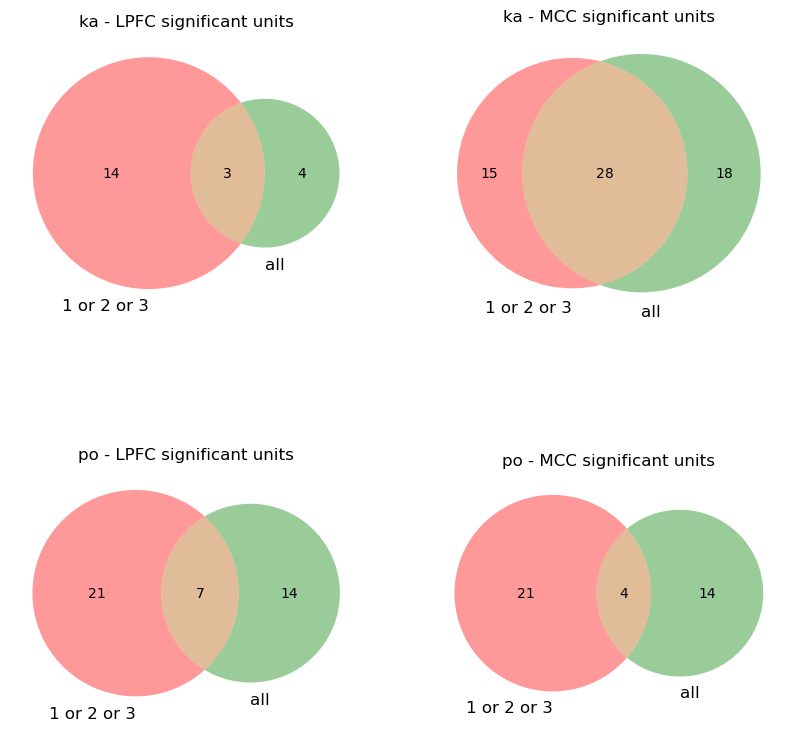

In [33]:
# plot venn diagram for random vs all units condition
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i, (monkey, area) in enumerate(product(['ka', 'po'], ['LPFC', 'MCC'])):
    ax = axs.flatten()[i]
    sum_123 = set(list_of_untis[f'target_1_{monkey}_{area}']) | set(list_of_untis[f'target_2_{monkey}_{area}']) | set(list_of_untis[f'target_3_{monkey}_{area}'])
    venn2([sum_123, set(list_of_untis[f'target_None_{monkey}_{area}'])], set_labels=['1 or 2 or 3', 'all'], ax=ax)
    ax.set_title(f'{monkey} - {area} significant units')

plt.show()

In [34]:
'''# print 10 units of all intersection
print("KA - MCC")
print_intersection(set(list_of_untis['target_1_mcc_ka']), set(list_of_untis['target_2_mcc_ka']), set(list_of_untis['target_3_mcc_ka']))
print("KA - LPFC")
print_intersection(set(list_of_untis['target_1_lpfc_ka']), set(list_of_untis['target_2_lpfc_ka']), set(list_of_untis['target_3_lpfc_ka']))
print("PO - MCC")
print_intersection(set(list_of_untis['target_1_mcc_po']), set(list_of_untis['target_2_mcc_po']), set(list_of_untis['target_3_mcc_po']))
print("PO - LPFC")
print_intersection(set(list_of_untis['target_1_lpfc_po']), set(list_of_untis['target_2_lpfc_po']), set(list_of_untis['target_3_lpfc_po']))'''

'# print 10 units of all intersection\nprint("KA - MCC")\nprint_intersection(set(list_of_untis[\'target_1_mcc_ka\']), set(list_of_untis[\'target_2_mcc_ka\']), set(list_of_untis[\'target_3_mcc_ka\']))\nprint("KA - LPFC")\nprint_intersection(set(list_of_untis[\'target_1_lpfc_ka\']), set(list_of_untis[\'target_2_lpfc_ka\']), set(list_of_untis[\'target_3_lpfc_ka\']))\nprint("PO - MCC")\nprint_intersection(set(list_of_untis[\'target_1_mcc_po\']), set(list_of_untis[\'target_2_mcc_po\']), set(list_of_untis[\'target_3_mcc_po\']))\nprint("PO - LPFC")\nprint_intersection(set(list_of_untis[\'target_1_lpfc_po\']), set(list_of_untis[\'target_2_lpfc_po\']), set(list_of_untis[\'target_3_lpfc_po\']))'

In [35]:
# print some example units


In [36]:
# venn diagram for None vs random
plt.figure()
venn2([set(list_of_untis[f'target_{target}_mcc']) for target in ['random', None]], set_labels=['random', 'None'])
plt.title(f'MCC significant units, N={len(list_of_untis["all_mcc"])}')
plt.show()

plt.figure()
venn2([set(list_of_untis[f'target_{target}_lpfc']) for target in ['random', None]], set_labels=['random', 'None'])
plt.title(f'LPFC significant units, N={len(list_of_untis["all_lpfc"])}')
plt.show()



KeyError: 'target_random_mcc'

<Figure size 640x480 with 0 Axes>

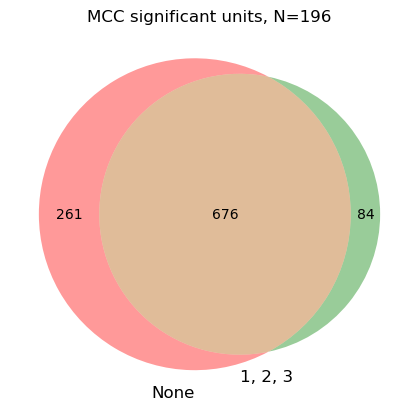

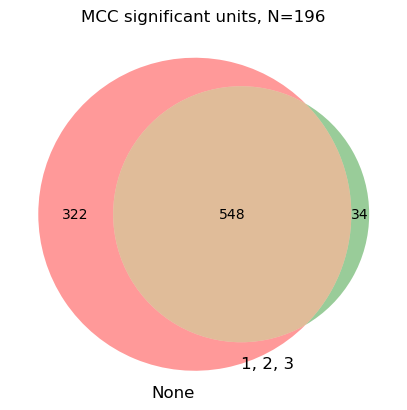

In [ ]:
# vann for None vs target 1 or 2 or 3
plt.figure()

target_1_2_3 = set(list_of_untis[f'target_1_lpfc']) | set(list_of_untis[f'target_2_lpfc']) | set(list_of_untis[f'target_3_lpfc'])
venn2([set(list_of_untis[f'target_{None}_lpfc']), target_1_2_3], set_labels=['None', '1, 2, 3'])
plt.title(f'MCC significant units, N={len(list_of_untis["all_mcc"])}')
plt.show()

plt.figure()
target_1_2_3 = set(list_of_untis[f'target_1_mcc']) | set(list_of_untis[f'target_2_mcc']) | set(list_of_untis[f'target_3_mcc'])
venn2([set(list_of_untis[f'target_{None}_mcc']), target_1_2_3], set_labels=['None', '1, 2, 3'])
plt.title(f'MCC significant units, N={len(list_of_untis["all_mcc"])}')
plt.show()

